In [1]:
!pip install transformers

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/9a/06/e4ec2a321e57c03b7e9345d709d554a52c33760e5015fdff0919d9459af0/transformers-4.35.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.1/123.1 kB 5.4 MB/s eta 0:00:00
  Obtaining dependency information for huggingface-hub<1.0,>=0.16.4 from https://files.pythonhosted.org/packages/ef/b5/b6107bd65fa4c96fdf00e4733e2fe5729bb9e5e09997f63074bb43d3ab28/huggingface_hub-0.18.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyyaml>=5.1 from https://files.pythonhosted.org/packages/28/09/55f715ddbf95a054b764b547f617e22f1d5e45d83905660e9a088078fe67/PyYAML-6.0.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for tokenizers<0.15,>=0.14 from https://files.pythonhosted.org/packages/7e/8e/9c0f7799da9a690ec29a7a7b6c0744d3f735e40951d2f62c8202faf3df6a/tokenizers-0.14.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency inf

In [2]:
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import sklearn
from transformers import AutoFeatureExtractor #generador de características

/Users/rodolfolobocarrasco/.pyenv/versions/3.11.6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cargando señales de audio

In [13]:
MyPath = pathlib.Path("/Users/rodolfolobocarrasco/Documents/projects/skeleton_env/machine-learning/machine_learning/data_sets")

Necesitamos utilizar un sample rate menor para ejemplificar utilizando transformers

In [14]:
sr = 16000

In [17]:
kick_signals = [
    librosa.load(p, sr = sr)[0] for p in MyPath.glob('kick/Copia de Bass Sample *.wav')
]

snare_signals = [
    librosa.load(p, sr = sr)[0] for p in MyPath.glob('snare/Copia de Snare Sample *.wav')
]

In [18]:
len(kick_signals)

40

Cargando un modelo que extrae características desde las señales de audio

In [19]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

/Users/rodolfolobocarrasco/.pyenv/versions/3.11.6/lib/python3.11/site-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [20]:
kick_inputs = feature_extractor(kick_signals, sampling_rate=sr, return_tensors="pt")

In [21]:
snare_inputs = feature_extractor(snare_signals, sampling_rate=sr, return_tensors="pt")

In [22]:
len(kick_inputs)

1

In [23]:
kick_inputs['input_values'].shape

torch.Size([40, 32000])

Obteniendo los arreglos que contienen la información que el modelo consiguió extraer del audio

In [24]:
kick_embeddings = kick_inputs['input_values']

In [25]:
snare_embeddings = snare_inputs['input_values']

Concatenamos los tensores-vectores en ```torch```

In [26]:
import torch

In [27]:
X = torch.cat((kick_embeddings, snare_embeddings), 0)

In [28]:
X.shape

torch.Size([80, 32000])

Aplicamos $t-\mathtt{SNE}$

In [29]:
from sklearn import manifold

In [30]:
tsne = manifold.TSNE(n_components = 2, random_state = 42)

In [31]:
transformed_data = tsne.fit_transform(X)

In [32]:
transformed_data.shape

(80, 2)

In [33]:
import pandas as pd

In [34]:
df_tsne = pd.DataFrame(transformed_data)
df_tsne['targets'] = 40*[1] + 40*[0]

In [35]:
df_tsne.columns = ['x','y','targets']

In [36]:
df_tsne.head(5)

,x,y,targets
0,6.611866,-4.113020,1
1,5.500803,-3.785679,1
2,3.845456,-4.395586,1
3,5.514779,0.884576,1
4,5.434247,-1.393771,1


In [37]:
import seaborn as sns

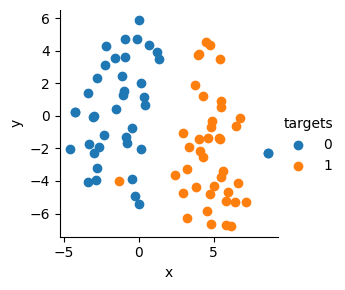

In [38]:
grid = sns.FacetGrid(df_tsne,hue = "targets")
grid.map(plt.scatter,"x","y").add_legend()

In [39]:
df_tsne.to_csv("../data_sets/audio_2d.csv")